In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import tiktoken

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "lagimik.github.io"
full_url = "https://lagimik.github.io"
path = "/PartnerCrucible/DataAISolutionArea"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL 
# need some way to control the recursion
def get_domain_hyperlinks(referer, url, path):
    clean_links = []

    if referer == domain:
        for link in set(get_hyperlinks(url)):
            clean_link = None

            # If the link is a URL
            if re.search(HTTP_URL_PATTERN, link):
                clean_link = link

            # If the link is not a URL, check if it is a relative link
            else:
                if link.startswith("/"):
                    link = url + link[1:]
                elif link.startswith("./"):
                    link = url + link[2:]
                elif link.startswith("#") or link.startswith("mailto:"):
                    continue
                else:
                    clean_link = url + "/" + path + "/" + link

            if clean_link is not None:
                if clean_link.endswith("/"):
                    clean_link = clean_link[:-1]
                clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

# implementation to crawl to a depth of 2 from the root to get the links from the crucible and whatever the content at teh other end is
def get_child_hyperlinks(url):
    clean_links = []
    local_domain = urlparse(url).netloc
    

    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL
        if re.search(HTTP_URL_PATTERN, link):
            clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = url + link[1:]
            elif link.startswith("./"):
                link = url + link[2:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            else:
                clean_link = url + "/" + path + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url,path):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc
    #local_domain = "lagimik.github.io/PartnerCrucible"
    file_path = local_domain
    
    # Create a queue to store the URLs to crawl
    # 2d array queue specifying url and refering domain
    queue = deque([[url + "/" + path, local_domain]])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url + "/" + path])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+ file_path+"/"):
            os.mkdir("text/" + file_path + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url, refering = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+ file_path+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        #Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(refering, url, path):
            print("--" + link)
            if link not in seen:
                queue.append([link, urlparse(link).netloc])
                seen.add(link)


        # Get the hyperlinks from the URL and add them to the queue
        #for link in get_domain_hyperlinks(local_domain, url, path):
        #    print("--" + link)
        #    for child_link in get_child_hyperlinks(link):
        #        if child_link not in seen:
        #            queue.append(child_link)
        #            seen.add(child_link)

crawl(full_url,path)

https://lagimik.github.io//PartnerCrucible/DataAISolutionArea
--https://microsoft.github.io/PartnerResources/azure/data-analytics-ai/openai
--https://docs.microsoft.com/en-us/azure/architecture/example-scenario/dataplate2e/data-platform-end-to-end?tabs=portal
--https://lnkd.in/eU4KMdP2
--https://lnkd.in/e5cRUCs7
--https://msuspartners.eventbuilder.com/EnablePurview
--https://partner.microsoft.com/en-us/training/assets/collection/azure-data-and-ai-partner-sales-acceleration-program-psap#
--https://techcommunity.microsoft.com/t5/security-compliance-and-identity/the-microsoft-purview-data-loss-prevention-ninja-training-is/ba-p/3659015
--https://lnkd.in/dfCKwWDN
--https://msuspartners.eventbuilder.com/AIMLPartnerPrep
--https://www.youtube.com/@MicrosoftPurview
--https://learn.microsoft.com/en-us/rest/api/purview
--https://lagimik.github.io//PartnerCrucible/DataAISolutionArea//PartnerCrucible/DataAISolutionArea/ContributorsGuide
--https://aka.ms/adx.blog
--https://lnkd.in/eUUVTiNQ
--https:/

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/tmp/ipykernel_19771/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,rosoft.com,rosoft.com. AI Demos Skip to main ...
1,blog,blog. \tAzure Data Explorer Blog - Microsoft ...
2,sof,sof. Newest 'azure-data-explorer+or+kql+or+kq...
3,arningjourney,arningjourney. Azure AI Learning Jour...
4,engineer learning path,engineer learning path. DP-203 certi...


<AxesSubplot: >

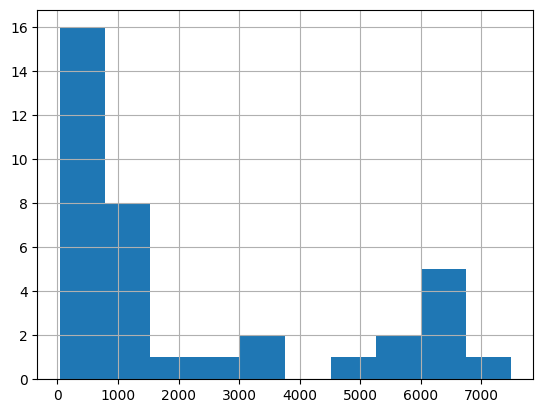

In [4]:


# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [5]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

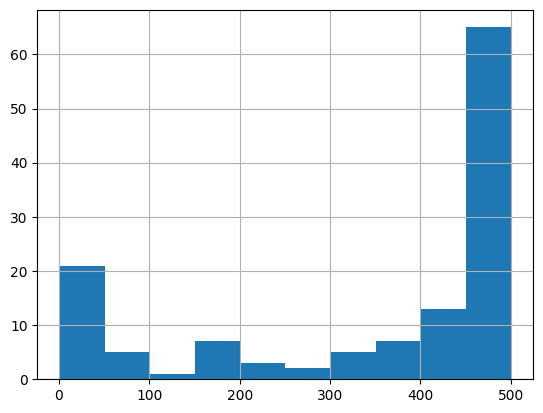

In [6]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [15]:
import openai
from ratelimit import limits, sleep_and_retry

# Set OpenAI API key
openai.api_key = ''

# Set rate limit parameters
RATE_LIMIT = 50  # Maximum number of requests per minute
RATE_PERIOD = 60  # Time period for rate limit in seconds

# Define rate limit decorator
@sleep_and_retry
@limits(calls=RATE_LIMIT, period=RATE_PERIOD)
def get_embedding(text):
    # Call OpenAI Embedding API to generate embedding
    embedding = openai.Embedding.create(input=text, engine='text-embedding-ada-002')['data'][0]['embedding']
    return embedding

# Generate embeddings with rate limiting
df['embeddings'] = df.text.apply(lambda x: get_embedding(x))
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,rosoft.com. AI Demos Skip to main ...,429,"[0.0013598980149254203, -0.025529107078909874,..."
1,blog. \tAzure Data Explorer Blog - Microsoft ...,441,"[0.0017209274228662252, -0.012642164714634418,..."
2,monitoring Power BI. relationships Prediction ...,470,"[-0.000707933446392417, -0.013479757122695446,..."
3,"\t\t\t 2,077 \t\t\t\t\t\t\tGeneral ...",472,"[0.00028307450702413917, -0.005938734859228134..."
4,"\t\t\t 1,094 \t\t\t\t\t\t\tCross hi...",489,"[-0.012034917250275612, -0.019477564841508865,..."


In [17]:
from openai.embeddings_utils import distances_from_embeddings

# this looked looked like duplication of previous cell
#df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
#df.to_csv('processed/embeddings.csv')
#df.head()


In [18]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,rosoft.com. AI Demos Skip to main ...,429,"[0.0013598980149254203, -0.025529107078909874,..."
1,blog. \tAzure Data Explorer Blog - Microsoft ...,441,"[0.0017209274228662252, -0.012642164714634418,..."
2,monitoring Power BI. relationships Prediction ...,470,"[-0.000707933446392417, -0.013479757122695446,..."
3,"\t\t\t 2,077 \t\t\t\t\t\t\tGeneral ...",472,"[0.00028307450702413917, -0.005938734859228134..."
4,"\t\t\t 1,094 \t\t\t\t\t\t\tCross hi...",489,"[-0.012034917250275612, -0.019477564841508865,..."


In [20]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [33]:
answer_question(df, question="what are good sources of learning?", debug=False)

'soft.com en us training modules explore azure openai, soft.com en us resources mysql developer learning journey ?OCID=mysql dev pdf MySQL page, and Azure Data Explorer 101 series Usage flow & Docs.'

In [36]:
answer_question(df, question="how to I manage timeseries data?")

'For near real-time telemetry and time-series analytics scenarios, use Data Explorer pools to easily ingest IoT events directly from Event Hubs or IoT Hubs. With Data Explorer pools, you can use Kusto queries (KQL) to perform time-series analysis, geospatial clustering, and machine learning enrichment.'